# Set up

In [ ]:
#!pip install causalml

In [ ]:
from platform import python_version

print(python_version())

3.7.11


In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae
from sklearn.metrics import roc_auc_score, auc, roc_curve, precision_recall_curve
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.model_selection import train_test_split
import warnings
import sys
from causalml.inference.meta import BaseSRegressor, BaseTRegressor, BaseRRegressor, BaseXRegressor

plt.style.use('fivethirtyeight')
rcParams['figure.figsize'] = 6,8
warnings.filterwarnings('ignore')

%matplotlib inline
%load_ext autoreload
%autoreload 2

pd.options.display.max_columns = 2000
pd.options.display.max_rows = 2000
pd.options.display.max_seq_items = 2000
pd.options.display.float_format = '{:.4f}'.format

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#Context


## Read in Data [P10]
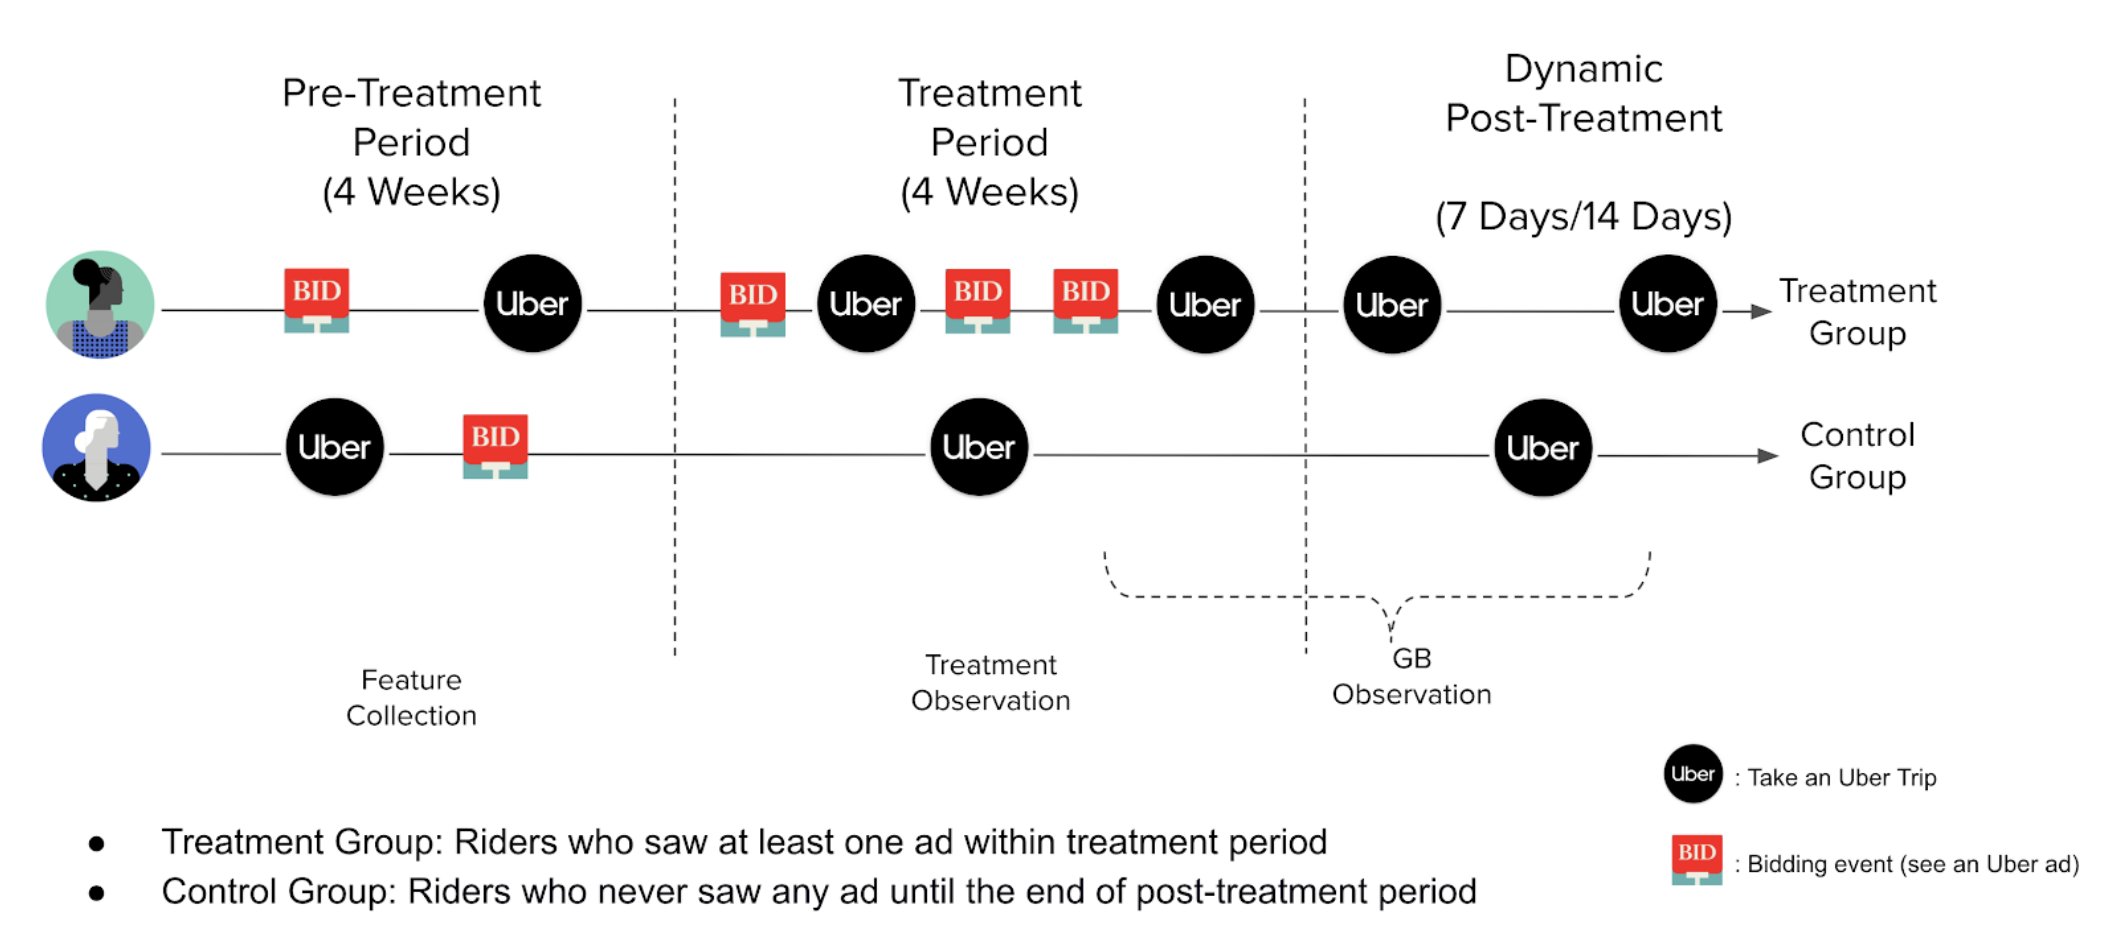

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/case2/case_2_data.csv')
print(df.shape)

(100000, 15)


In [ ]:
OUTCOME_COL = 'y_col'
TREATMENT_COL = 'target'
SCORE_COL = 'pihat'
NAN_INT = -98765    # A random integer to impute missing values with

In [ ]:
INFERENCE_FEATURES = [
 'Feature_0',
 'Feature_1',
 'Feature_2',
 'Feature_3',
 'Feature_4',
 'Feature_5',
 'Feature_6',
 'Feature_7',
 'Feature_8',
 'Feature_9'
]

# Validation

In [ ]:
def prepare_inputs(df, p_col='pihat', w_col='target', y_col='y_col', inference_features=INFERENCE_FEATURES):
    X =df[INFERENCE_FEATURES].values
    p = df[p_col].values
    w = df[w_col].values
    df[y_col] = df[y_col].fillna(0)
    y = df[y_col].values

    return X, p, w, y 

In [ ]:
def run_learners(df, p_col='pihat', w_col='target', y_col='y_col', k=5):
    model_dict = {}
    
    for base_learner,label_l in zip([BaseSRegressor, BaseTRegressor, BaseXRegressor],['S','T','X']):
        for model,label_m in zip([XGBRegressor],['XGB']):
            X, p, w, y = prepare_inputs(df, p_col, w_col, y_col)
               
            if label_l == 'S':
                learner = base_learner(learner=model(max_depth=8, eta = 0.01, seed = 22))
                ate, lb, ub = learner.estimate_ate(X=X,treatment=w,y=y,return_ci=True)  
            elif label_l == 'T':
                learner = base_learner(learner=model(max_depth=8, eta = 0.01))
                ate, lb, ub = learner.estimate_ate(X=X,treatment=w,y=y)  
            elif label_l == 'X':
                learner = base_learner(learner=model(max_depth=8, eta = 0.01))
                ate, lb, ub = learner.estimate_ate(X=X,p=p,treatment=w,y=y)  
            model_dict[label_l + '_' + label_m] = learner 
    return model_dict

In [ ]:
msk = np.random.rand(len(df)) < 0.8
train = df[msk]
val = df[~msk]
models = run_learners(train, y_col=OUTCOME_COL, p_col=SCORE_COL)


[01:20:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:20:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:21:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:21:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:21:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:21:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:21:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
#@title performance function

from causalml.metrics.visualize import plot_lift, plot_qini, plot_gain, plot_tmlegain, auuc_score, qini_score
from causalml.propensity import ElasticNetPropensityModel
from sklearn.metrics import r2_score, mean_squared_error
import logging
from collections import defaultdict

logging.basicConfig()
logger = logging.getLogger("NBOE")
logger.setLevel(logging.INFO)
MU_PRED = "mu_pred"  # base learner prediction
MU_PRED_STAGE2 = "mu_pred_stage2"  # second stage base learner prediction
TAU_PRED = "tau_pred"  # treatment effect prediction
TAU_ACTUAL = "tau_actual"  # 'actual' treatment effect from base learner
DELTA_PRED = "delta_gb_pred"  # treatment effect prediction


def performance(df_train, df_val, model_dict, val_cols, inference_col, y_col, p_col, treatment_col):
    """Output validation result on test_df

    Args:
        df_train (pandas.DataFrame): training data set
        df_val (pandas.DataFrame): validation data set
        model_dict (dict): saved model
        val_cols (List[string]): a list of columns need for validation purpose,
                           usually including (id, treatment_col, score_col,
                           label_col etc.)
        inference_col (list of str): a list of columns that used in learner for inference
        y_col (string): outcome column name
        p_col (string): propensity score column name
        treatment_col: column name indicating treatmen vs control
    """

    val_cols = val_cols + [y_col]

    # meta learner prediction on each steps
    prediction_dict = {}  # dictionary holds model prediction results in each steps
    base_model_performance_df = pd.DataFrame()
    for model_name, learner in model_dict.items():
        print(model_name)

        scored_val_df = score_with_meta_learner(
            learner, df_val, inference_col, val_cols=val_cols,
            p_col=p_col, treatment_col=treatment_col, label_col=y_col
        )

        scored_train_df = score_with_meta_learner(
            learner, df_train, inference_col, val_cols=val_cols,
            p_col=p_col, treatment_col=treatment_col, label_col=y_col
        )

        prediction_dict[model_name + ' val'] = scored_val_df
        prediction_dict[model_name + ' train'] = scored_train_df

        # base models performance validation
        # dataframe holds base model performance in each steps
        base_model_performance_df = pd.DataFrame(columns=['model', 'segment', 'rmse', 'smape',
                                                          'rsquare', 'learner', 'type'])
        logger.info("Validating {} base model".format(model_name))
        logger.info("Validation result on hold out data")
        base_model_performance = validate_model(scored_val_df, treatment_col,
                                                label_col=y_col)
        base_model_performance['learner'] = model_name
        base_model_performance['type'] = 'validation'
        logger.info(base_model_performance)
        base_model_performance_df.append(base_model_performance)

        logger.info("Validation result on training data")
        base_model_performance = validate_model(scored_train_df, treatment_col,
                                                label_col=y_col)
        base_model_performance['learner'] = model_name
        base_model_performance['type'] = 'train'
        logger.info(base_model_performance)
        base_model_performance_df.append(base_model_performance)
        logger.info('-----------------------------------------------------------------')

    # prepare dataframe with model name and treatment effect prediction
    pred_df_train = df_train[['user_uuid'] + [y_col, treatment_col]].reset_index(drop=True)
    pred_df_val = df_val[['user_uuid'] + [y_col, treatment_col]].reset_index(drop=True)
    # Join prediction dict to get treatment effect prediction
    for model_name, learner in model_dict.items():
        pred_df_val = pred_df_val.merge(
            prediction_dict[model_name + ' val'][['user_uuid', 'delta_gb_pred']],
            on='user_uuid'
        )
        pred_df_val.rename(columns={'delta_gb_pred': model_name + ' val'}, inplace=True)
        pred_df_train = pred_df_train.merge(
            prediction_dict[model_name + ' train'][['user_uuid', 'delta_gb_pred']],
            on='user_uuid'
        )
        pred_df_train.rename(columns={'delta_gb_pred': model_name + ' train'}, inplace=True)

    pred_df_train.drop('user_uuid', axis=1, inplace=True)
    pred_df_val.drop('user_uuid', axis=1, inplace=True)

    # plot lift Curve
    plot_lift_curve(pred_df_val, y_col, treatment_col)
    # plot Uplift Curve
    plot_uplift_curve(pred_df_val, y_col, treatment_col)
    # plot qini curve
    plot_qini_curve(pred_df_val, y_col, treatment_col)
    # output AUUC score
    get_auuc(pred_df_val, y_col, treatment_col)
    # output qini score
    get_qini(pred_df_val, y_col, treatment_col)
    # plot TMLE curve
    plot_tmle_curve(pred_df_val.join(df_val[inference_col]), inference_col, y_col, treatment_col, p_col)

    return pred_df_val, base_model_performance_df


def validate_model(scored_df, treatment_col, label_col):
    """ Validate the base model performence for each segment
        (Overall, Treatment and Control) including the metric:
        rmse, smape and rsquere.

    Args:
        scored_df (pandas.DataFrame): a dataframe of model results of each steps
        treatment_col (str): column name of whether in treatment of control
        label_col (str): column name of outcome
    Returns:
        validate_result_df (pd.DataFrame): a dataframe of base model performance of each steps
    """
    validate_result_df = pd.DataFrame(
        columns=['model', 'segment', 'rmse', 'smape', 'rsquare'])
    is_treatment = scored_df[treatment_col].astype(bool)
    validate_iterator = zip(['mu_model', 'tau_model'],
                            [MU_PRED, TAU_PRED],
                            [label_col, TAU_ACTUAL])

    for m_type, pred, actual in validate_iterator:
        validate_result_dict = defaultdict(list)
        rmse_list, smape_list, rsquare_list = [], [], []
        total_actual, total_pred = scored_df[actual], scored_df[pred]
        tr_actual, tr_pred = scored_df[is_treatment][actual], scored_df[is_treatment][pred]
        cr_actual, cr_pred = scored_df[~is_treatment][actual], scored_df[~is_treatment][pred]
        data_iterator = [[total_actual, total_pred], [tr_actual, tr_pred],
                         [cr_actual, cr_pred]]
        for actual, pred in data_iterator:
            rmse_list.append(np.sqrt(mean_squared_error(actual, pred)))
            smape_list.append(_smape(actual, pred))
            rsquare_list.append(r2_score(actual, pred))

        validate_result_dict['model'] = [m_type] * 3
        validate_result_dict['segment'] = ['overall', 'treatment', 'control']
        validate_result_dict['rmse'] = rmse_list.copy()
        validate_result_dict['smape'] = smape_list.copy()
        validate_result_dict['rsquare'] = rsquare_list.copy()

        validate_result_df = validate_result_df.append(
            pd.DataFrame(validate_result_dict))
    return validate_result_df


def score_with_meta_learner(learner, df, inference_col,
                            val_cols, p_col, treatment_col,
                            label_col):
    """ Generate the base model prediction for each steps and
        separately for Control and Treatment

    Args:
        learner: a model to estimate outcomes and treatment effects from causalml.inference.meta
        df (pd.DataFrame): input data frame
        inference_col (list of str): a list of columns that used in learner for inference
        val_cols (list of str): a list of columns need for validation purpose, usually including
                                (id, treatment_col, score_col, label_col etc.)
        p_col (str): column name of propensity score
        treatment_col (str): column name of whether in treatment of control
        label_col (str): column name of outcome
    Returns:
        score_val_df (pd.DataFrame): a dataframe of model results of each steps
    """
    X = df[inference_col].values
    w = df[treatment_col].astype(int).values
    is_treatment = df[treatment_col].astype(bool)

    X_tr = df[is_treatment][inference_col].values
    X_cr = df[~is_treatment][inference_col].values
    w_tr = df[is_treatment][treatment_col].astype(int).values
    w_cr = df[~is_treatment][treatment_col].astype(int).values

    if isinstance(learner, BaseTRegressor):
        scored_val_df = score_with_t_learner(learner, df, val_cols, X_tr,
                                             X_cr, w_tr, w_cr, label_col,
                                             is_treatment)

    elif isinstance(learner, BaseSRegressor):
        scored_val_df = score_with_s_learner(learner, df, val_cols, X,
                                             w, label_col)

    elif isinstance(learner, BaseRRegressor):
        scored_val_df = score_with_r_learner(learner, df, val_cols, X,
                                             w, label_col)

    elif isinstance(learner, BaseXRegressor):
        scored_val_df = score_with_x_learner(learner, df, val_cols, X_tr,
                                             X_cr, label_col, is_treatment,
                                             p_col)

    return (scored_val_df)


def score_with_t_learner(learner, df, val_cols, X_tr, X_cr, w_tr, w_cr,
                         label_col, is_treatment):
    # initalize results dataframe for treatment and control
    scored_val_tr = df[is_treatment][val_cols]
    scored_val_cr = df[~is_treatment][val_cols]

    # Treatment
    # base learner prediction
    scored_val_tr[MU_PRED] = learner.models_t[1].predict(
        X_tr)  # models_t[1] holds the model instance
    # treatment effect prediction
    scored_val_tr[TAU_PRED] = learner.predict(X_tr, w_tr)
    # 'actual' treatment effect from actual outcome and base learner prediction
    scored_val_tr[TAU_ACTUAL] = _get_tau_actual(scored_val_tr, label_col,
                                                MU_PRED, w_tr)
    scored_val_tr[DELTA_PRED] = scored_val_tr[TAU_PRED]

    # control
    scored_val_cr[MU_PRED] = learner.models_c[1].predict(
        X_cr)  # models_c[1] holds the model instance
    # treatment effect prediction
    scored_val_cr[TAU_PRED] = learner.predict(X_cr, w_tr)
    # 'actual' treatment effect from actual outcome and base learner prediction
    scored_val_cr[TAU_ACTUAL] = _get_tau_actual(scored_val_cr, label_col,
                                                MU_PRED, w_cr)
    scored_val_cr[DELTA_PRED] = scored_val_cr[TAU_PRED]

    scored_val_df = pd.concat([scored_val_tr, scored_val_cr], axis=0)
    return scored_val_df


def score_with_s_learner(learner, df, val_cols, X, w, label_col):
    # initalize results dataframe
    scored_val_df = df[val_cols]

    # base learner prediction
    X_temp = np.hstack((w.reshape((-1, 1)), X))
    scored_val_df[MU_PRED] = learner.models[1].predict(
        X_temp)  # models[1] holds the model instance
    # treatment effect prediction
    scored_val_df[TAU_PRED] = learner.predict(X, w)
    # 'actual' treatment effect from actual outcome and base learner prediction
    scored_val_df[TAU_ACTUAL] = _get_tau_actual(scored_val_df, label_col,
                                                MU_PRED, w)
    scored_val_df[DELTA_PRED] = scored_val_df[TAU_PRED]
    return scored_val_df


def score_with_r_learner(learner, df, val_cols, X, w, label_col):
    # initalize results dataframe
    scored_val_df = df[val_cols]
    # base learner prediction
    scored_val_df[MU_PRED] = learner.model_mu.predict(X)
    # treatment effect prediction
    scored_val_df[TAU_PRED] = learner.models_tau[1].predict(
        X)  # models[1] holds the model instance
    # 'actual' treatment effect from actual outcome and base learner prediction
    scored_val_df[TAU_ACTUAL] = _get_tau_actual(scored_val_df, label_col,
                                                MU_PRED, w)
    scored_val_df[DELTA_PRED] = scored_val_df[TAU_PRED]
    return scored_val_df


def score_with_x_learner(learner, df, val_cols, X_tr, X_cr, label_col,
                         is_treatment, p_col):
    # initalize results dataframe for treatment and control
    scored_val_tr = df[is_treatment][val_cols]
    scored_val_cr = df[~is_treatment][val_cols]

    # Treatment
    # base learner prediction
    scored_val_tr[MU_PRED] = learner.models_mu_t[1].predict(
        X_tr)  # models_mu_t[1] holds the model instance
    # treatment effect prediction
    scored_val_tr[TAU_PRED] = learner.models_tau_t[1].predict(
        X_tr)  # models_tau_t[1] holds the model instance
    # base learner prediction step 2
    scored_val_tr[MU_PRED_STAGE2] = learner.models_mu_c[1].predict(
        X_tr)  # models_tau_t[1] holds the model instance
    # 'actual' treatment effect from actual outcome and base learner prediction
    scored_val_tr[TAU_ACTUAL] = scored_val_tr[label_col] - \
                                scored_val_tr[MU_PRED_STAGE2]
    scored_val_tr[DELTA_PRED] = learner.predict(
        X=X_tr, p=df[is_treatment][p_col].values)

    # base learner prediction
    scored_val_cr[MU_PRED] = learner.models_mu_c[1].predict(
        X_cr)  # models_tau_t[1] holds the model instance
    # treatment effect prediction
    scored_val_cr[TAU_PRED] = learner.models_tau_c[1].predict(X_cr)
    # base learner prediction step 2
    scored_val_cr[MU_PRED_STAGE2] = learner.models_mu_t[1].predict(X_cr)
    # 'actual' treatment effect from actual outcome and base learner prediction
    scored_val_cr[TAU_ACTUAL] = scored_val_cr[MU_PRED_STAGE2] - \
                                scored_val_cr[label_col]
    scored_val_cr[DELTA_PRED] = learner.predict(
        X=X_cr, p=df[~is_treatment][p_col].values)

    scored_val_df = pd.concat([scored_val_tr, scored_val_cr], axis=0)
    return scored_val_df


def plot_lift_curve(pred_df, y_col, treatment_col):
    plot_lift(pred_df, outcome_col=y_col,
              treatment_col=treatment_col, figsize=(8, 8))


def plot_uplift_curve(pred_df, y_col, treatment_col):
    plot_gain(pred_df, outcome_col=y_col,
              treatment_col=treatment_col, figsize=(8, 8))


def plot_qini_curve(pred_df, y_col, treatment_col):
    plot_qini(pred_df, outcome_col=y_col,
              treatment_col=treatment_col, figsize=(8, 8))


def plot_tmle_curve(pred_df, inference_col, y_col, treatment_col, p_col):
    pred_df[p_col] = 0.5
    plot_tmlegain(pred_df, inference_col, outcome_col=y_col,
                  treatment_col=treatment_col, p_col=p_col)


def get_auuc(pred_df, y_col, treatment_col):
    auuc_df = pd.DataFrame(auuc_score(pred_df, outcome_col=y_col,
                                      treatment_col=treatment_col, normalize=False)).reset_index()
    auuc_df.columns = ['Learner', 'auuc']
    auuc_df['Lift'] = (auuc_df['auuc'] /
                       auuc_df[auuc_df.Learner == 'Random'].auuc.values) - 1
    auuc_df = auuc_df.sort_values('auuc', ascending=False)
    logger.info(auuc_df)
    return auuc_df


def get_qini(pred_df, y_col, treatment_col):
    qini_df = pd.DataFrame(qini_score(pred_df, outcome_col=y_col,
                                      treatment_col=treatment_col, normalize=False)).reset_index()
    qini_df.columns = ['Learner', 'qini']
    qini_df = qini_df.sort_values('qini', ascending=False)
    logger.info(qini_df)
    return qini_df


def _recalibrate_propensity(df, treatment_col, PROPENSITY_FEATURES):
    p_model = ElasticNetPropensityModel()
    X = df[PROPENSITY_FEATURES]
    return p_model.fit_predict(X, df[treatment_col])


def _smape(true, pred):
    return 2. * np.mean(np.abs(true - pred) / (np.abs(true) + np.abs(pred)))


def _get_tau_actual(df, y_col, mu_pred_col, is_treatment):
    """Return actual treatment effect
    """
    sign = (is_treatment - .5) * 2.
    return df[y_col] - df[mu_pred_col] * sign


S_XGB


INFO:NBOE:Validating S_XGB base model
INFO:NBOE:Validation result on hold out data
INFO:NBOE:       model    segment    rmse  smape  rsquare learner        type
0   mu_model    overall  5.0273 0.1951   0.0657   S_XGB  validation
1   mu_model  treatment  5.0061 0.1902   0.0808   S_XGB  validation
2   mu_model    control  5.0480 0.1998   0.0358   S_XGB  validation
0  tau_model    overall 29.5667 1.7732  -0.8971   S_XGB  validation
1  tau_model  treatment  5.1930 1.6218  -0.0761   S_XGB  validation
2  tau_model    control 41.2970 1.9218 -55.6301   S_XGB  validation
INFO:NBOE:Validation result on training data
INFO:NBOE:       model    segment    rmse  smape  rsquare learner   type
0   mu_model    overall  4.6554 0.1813   0.2015   S_XGB  train
1   mu_model  treatment  4.6542 0.1780   0.2215   S_XGB  train
2   mu_model    control  4.6566 0.1846   0.1708   S_XGB  train
0  tau_model    overall 29.4421 1.7527  -0.8711   S_XGB  train
1  tau_model  treatment  4.7195 1.5861  -0.0283   S_XGB  trai

T_XGB


INFO:NBOE:Validating T_XGB base model
INFO:NBOE:Validation result on hold out data
INFO:NBOE:       model    segment    rmse  smape  rsquare learner        type
0   mu_model    overall  5.0359 0.1954   0.0625   T_XGB  validation
1   mu_model  treatment  5.0202 0.1907   0.0756   T_XGB  validation
2   mu_model    control  5.0514 0.2000   0.0345   T_XGB  validation
0  tau_model    overall 29.5600 1.7478  -0.8964   T_XGB  validation
1  tau_model  treatment  5.4072 1.5875  -0.1602   T_XGB  validation
2  tau_model    control 41.2606 1.9050 -55.2252   T_XGB  validation
INFO:NBOE:Validation result on training data
INFO:NBOE:       model    segment    rmse  smape  rsquare learner   type
0   mu_model    overall  4.4660 0.1739   0.2651   T_XGB  train
1   mu_model  treatment  4.4361 0.1698   0.2927   T_XGB  train
2   mu_model    control  4.4960 0.1779   0.2270   T_XGB  train
0  tau_model    overall 29.4541 1.6651  -0.8723   T_XGB  train
1  tau_model  treatment  4.3249 1.4347   0.0495   T_XGB  trai

X_XGB


INFO:NBOE:Validating X_XGB base model
INFO:NBOE:Validation result on hold out data
INFO:NBOE:       model    segment   rmse  smape  rsquare learner        type
0   mu_model    overall 5.0359 0.1954   0.0625   X_XGB  validation
1   mu_model  treatment 5.0202 0.1907   0.0756   X_XGB  validation
2   mu_model    control 5.0514 0.2000   0.0345   X_XGB  validation
0  tau_model    overall 5.0909 1.5152   0.0275   X_XGB  validation
1  tau_model  treatment 5.0700 1.5175   0.0266   X_XGB  validation
2  tau_model    control 5.1113 1.5130   0.0285   X_XGB  validation
INFO:NBOE:Validation result on training data
INFO:NBOE:       model    segment   rmse  smape  rsquare learner   type
0   mu_model    overall 4.4660 0.1739   0.2651   X_XGB  train
1   mu_model  treatment 4.4361 0.1698   0.2927   X_XGB  train
2   mu_model    control 4.4960 0.1779   0.2270   X_XGB  train
0  tau_model    overall 4.5316 1.3795   0.2343   X_XGB  train
1  tau_model  treatment 4.5359 1.3869   0.2358   X_XGB  train
2  tau_mode

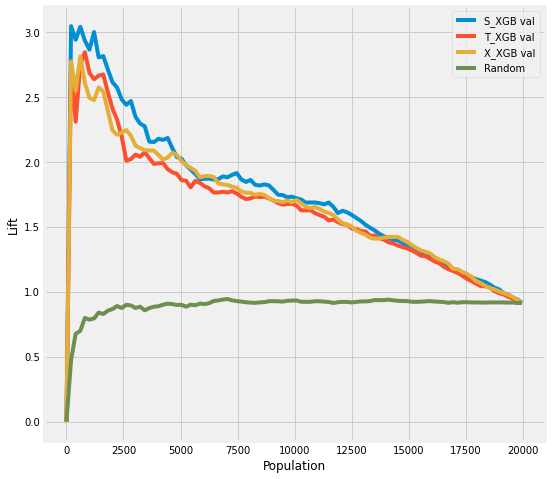

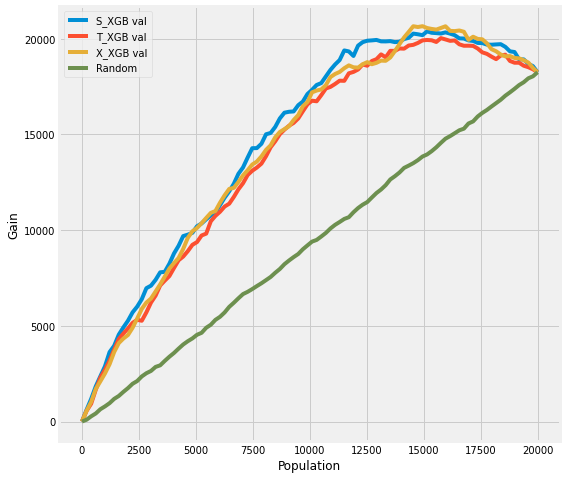

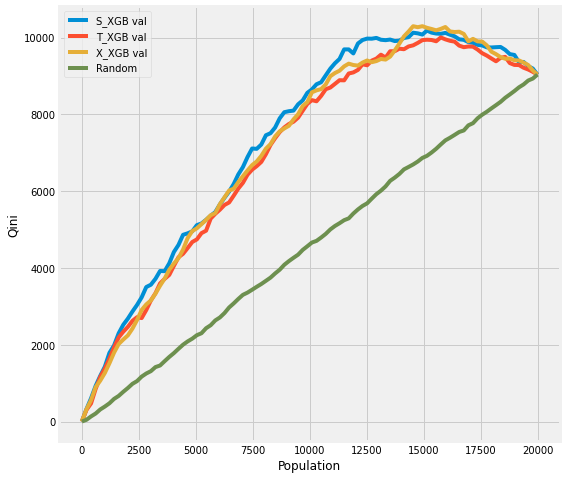

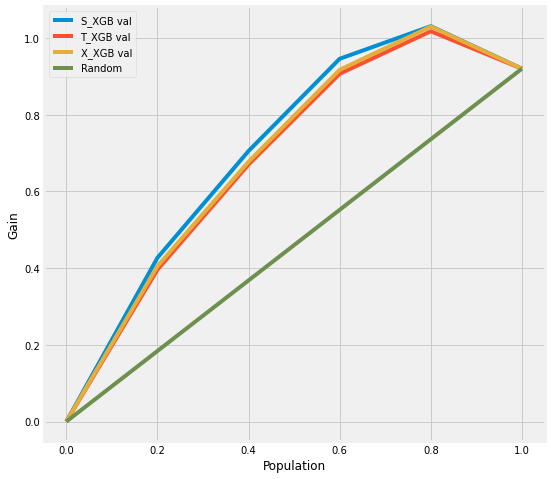

(        y_col  target  S_XGB val  T_XGB val  X_XGB val
 0     13.3014       1     0.0995    -1.8196    -0.0733
 1     20.8212       1     0.2219     0.6124     0.4459
 2     21.5730       0    -0.2963    -1.7178    -1.1946
 3     21.0108       0     0.7733     1.2138     0.3791
 4     21.7628       0    -0.0717    -2.3117    -0.2497
 ...       ...     ...        ...        ...        ...
 19969 19.8223       1    -0.0267    -0.8554    -0.1082
 19970 18.9325       1    -0.3301    -1.1489    -0.8531
 19971 21.0155       1     0.6293     0.9648     0.9213
 19972 21.6576       0     0.6960     0.5077     0.7896
 19973 24.8090       0     0.1511    -0.5237     0.0797
 
 [19974 rows x 5 columns], Empty DataFrame
 Columns: [model, segment, rmse, smape, rsquare, learner, type]
 Index: [])

In [ ]:
val_cols = ['user_uuid', TREATMENT_COL]
performance(train, val, models, val_cols, INFERENCE_FEATURES, OUTCOME_COL, SCORE_COL, TREATMENT_COL )